Implementing Amitabha-Bose Model for Phase Precession

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [99]:

# ================= PARAMETERS (Appendix B) =================
Cm = 20.0

gCa = 4.4
gK = 8.0
gL = 2.0

VCa = 120.0
VK = -84.0
VL = -60.0

gip = 1.0   # I -> P
gpi = 1.0   # P -> I
gti = 1.0   # T -> I

vIP = -80.0
vPI = 80.0
vTI = -80.0

Ip0 = 105.0
Ii0 = 120.0
It0 = 92.0

phi = 0.009

v1 = -1.2
v2 = 18.0

v3p = 2.0
v3i = -25.0
v3t = 2.0

v4p = 30.0
v4i = 10.0
v4t = 30.0

alpha = 2.0
beta = 1.0
v5 = 0.0
v6 = 10.0

In [100]:
def m_inf(v):
    return 0.5 * (1 + np.tanh((v - v1) / v2))

def w_inf(v, v3, v4):
    return 0.5 * (1 + np.tanh((v - v3) / v4))

def tau_w(v, v3, v4):
    return 1 / np.cosh((v - v3) / (2 * v4))


# Pulse input to pyramidal cell (place field)
def I_pulse(t, amp=30, t_on=4000, t_off=4200):
    if t_on <= t <= t_off:
        return amp
    else:
        return 0.0


# Synapse dynamics
def ds_dt(s, Vpre):
    return alpha*(1 - s)*0.5*(1 + np.tanh((Vpre - v5)/v6)) - beta*s

In [101]:
def ode_dynamics(state, t):

    Vp, Vi, Vt, wp, wi, wt, sip, spi, sti = state

    Ip = Ip0 + I_pulse(t)
    Ii = Ii0
    It = It0

    # Voltage equations
    dVp = ( -gCa*m_inf(Vp)*(Vp - VCa)
            -gK*wp*(Vp - VK)
            -gL*(Vp - VL)
            -sip*gip*(Vp - vIP)
            + Ip ) / Cm

    dVi = ( -gCa*m_inf(Vi)*(Vi - VCa)
            -gK*wi*(Vi - VK)
            -gL*(Vi - VL)
            -spi*gpi*(Vi - vPI)
            -sti*gti*(Vi - vTI)
            + Ii ) / Cm

    dVt = ( -gCa*m_inf(Vt)*(Vt - VCa)
            -gK*wt*(Vt - VK)
            -gL*(Vt - VL)
            + It ) / Cm 

    # Gating variables
    dwp = phi * (w_inf(Vp, v3p, v4p) - wp) / tau_w(Vp, v3p, v4p)
    dwi = phi * (w_inf(Vi, v3i, v4i) - wi) / tau_w(Vi, v3i, v4i)
    dwt = phi * (w_inf(Vt, v3t, v4t) - wt) / tau_w(Vt, v3t, v4t)

    # Synapses
    dsip = ds_dt(sip, Vi)   # I -> P
    dspi = ds_dt(spi, Vp)   # P -> I
    dsti = ds_dt(sti, Vt)   # T -> I

    return [dVp, dVi, dVt, dwp, dwi, dwt, dsip, dspi, dsti]

In [102]:
init_state = [-60, -60, -60, 0.1, 0.1, 0.1, 0, 0, 0]

t = np.linspace(0, 10000, 100000)
solution = odeint(ode_dynamics, init_state, t)
Vp_sol = solution[:,0]
Vi_sol = solution[:,1]
Vt_sol = solution[:,2] 
w_p_sol = solution[:,3]
w_i_sol = solution[:,4]
w_t_sol = solution[:,5]
s_ip_sol = solution[:,6]
s_pi_sol = solution[:,7]
s_ti_sol = solution[:,8]






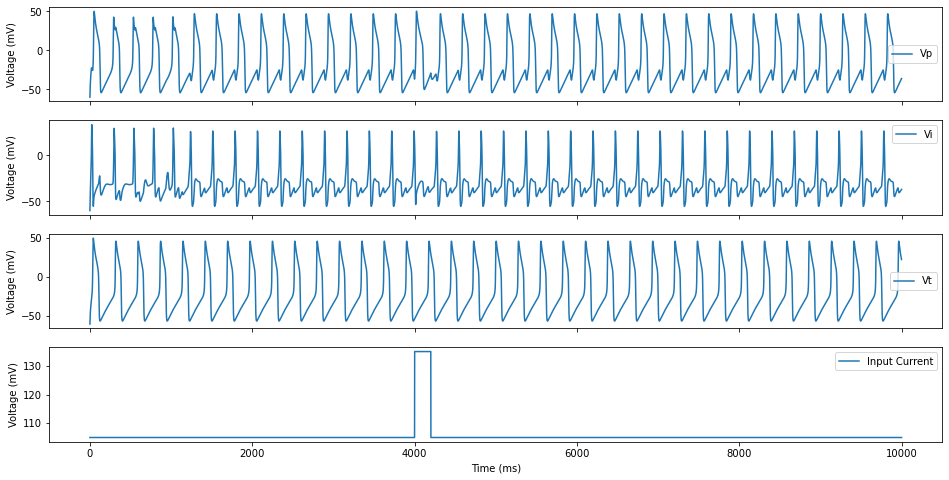

In [103]:
Ip_trace = np.array([Ip0 + I_pulse(tt) for tt in t])

fig,ax = plt.subplots(4,1,figsize=(16,8), sharex=True)
ax[0].plot(t, Vp_sol, label="Vp")
ax[1].plot(t, Vi_sol, label="Vi")
ax[2].plot(t, Vt_sol, label="Vt")
ax[3].plot(t, Ip_trace, label="Input Current")

for i in range(4):
    ax[i].legend()
    ax[i].set_ylabel("Voltage (mV)")

plt.xlabel("Time (ms)")
plt.show()

Text(0.5, 0, 'Time (ms)')

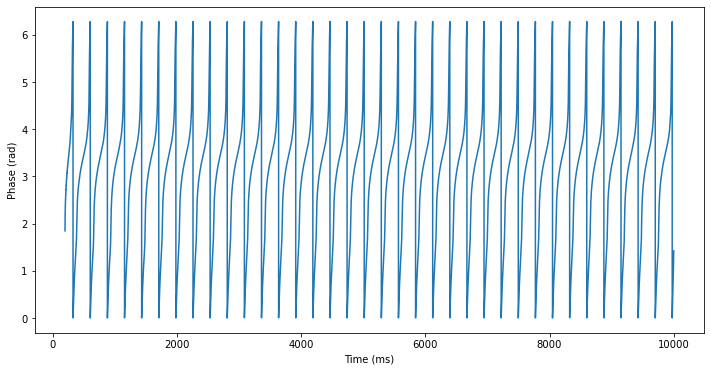

In [111]:
from scipy.signal import hilbert

theta_signal = Vt_sol[2000:]   # use thalamic cell as theta reference

analytic_signal = hilbert(theta_signal)
phase = np.angle(analytic_signal)      # in [-pi, pi]
phase = np.mod(phase, 2*np.pi)         # convert to [0, 2pi]
plt.figure(figsize=(12,6))
plt.plot(t[2000:], phase)
plt.ylabel("Phase (rad)")
plt.xlabel("Time (ms)")


ValueError: x and y must have same first dimension, but have shapes (37,) and (36,)

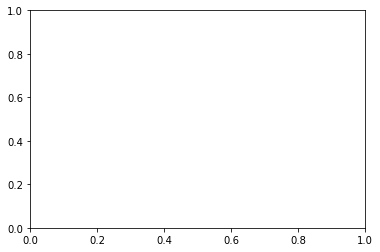

In [113]:
spike_times = []
threshold = 20

for i in range(1, len(Vp_sol)):
    if Vp_sol[i-1] < threshold and Vp_sol[i] >= threshold:
        spike_times.append(t[i])

spike_times = np.array(spike_times)
spike_idx = (spike_times / (t[1]-t[0])).astype(int)
spike_idx = spike_idx[spike_idx < len(phase)]
spike_phases = phase[spike_idx]
plt.plot(spike_times, spike_phases)
plt.xlabel("Time (ms)")
plt.ylabel("Theta phase (rad)")
plt.title("Phase precession")
plt.show()



In [106]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(Vi_sol)
period = np.mean(np.diff(t[peaks]))
freq = 1000/period  # if t is ms
print(freq)


11.17475989127152
